# HuBMAP - Efficient Sampling Ensemble (deepflash2, pytorch, fastai) [train]

> Kernel for model training with efficient region based sampling.

Requires deepflash2 (git version), zarr, and segmentation-models-pytorch


## Overview

1. Installation and package loading
2. Helper functions and patches
3. Configuration
4. Training

### Inputs
- https://www.kaggle.com/matjes/hubmap-zarr converted images (downscaled with factor 2)
- https://www.kaggle.com/matjes/hubmap-labels-pdf-0-5-0-25-0-01 masks and weights for sampling

### Versions
- V7: Fixed augmentations in deepflash2 `RandomTileDataset` config (random zoom) - LB 0.913
- V8: Adding *albumentations* transforms, switching to Cross-entropy loss

## Motivation

### Background

A glomerulus is a network of small blood vessels located at the beginning of a nephron in the kidney ([Wikipedia](https://en.wikipedia.org/wiki/Glomerulus_(kidney))
)). Glomeruli are mainly found in the renal **cortex**, while the renal **medulla** contains mainly the renal tubule. Since we are dealing with biological structures, the separation is not not absolute and the transitions are not always perfectly sharp.

![Diagram of a nephron](http://s3-us-west-2.amazonaws.com/courses-images/wp-content/uploads/sites/1842/2017/05/26234530/m9skcbftjqzrokkkopam.png)
[Diagram of a nephron from libretexts.org, Introductory and General Biology](https://bio.libretexts.org/Bookshelves/Introductory_and_General_Biology/Book%3A_General_Biology_(Boundless)/41%3A_Osmotic_Regulation_and_the_Excretory_System/41.4%3A_Human_Osmoregulatory_and_Excretory_Systems/41.4B%3A_Nephron%3A_The_Functional_Unit_of_the_Kidney)

### Key Idea

A common approach to deal with the very large (>500MB - 5GB) TIFF files in the dataset is to decompose the images in smaller patches/tiles, for instance by using a sliding window apporach.
> **Knowing that the glomeruli are mainly found in the cortex, we should focus on this region during training**. 

Instead of preprocessing the images and saving them into fixed tiles, we sample tiles from the entire images with a higher probability on tiles that contain glumeroli and cortex. Have a look at [this kernel](https://www.kaggle.com/matjes/hubmap-labels-pdf-0-5-0-25-0-01) for more details.


## Advantages of this approach

In combination with [deepflash2](https://github.com/matjesg/deepflash2/tree/master/) and the deepflash2 [pytorch datasets](https://matjesg.github.io/deepflash2/data.html#Datasets) in particular, this approach has several advantages:
- no preprocessing of the data (only saving them to .zarr files for memory efficient loading)
    - flexible tile shapes (input shapes, e.g. 1024, 512, 256) at runtime
    - flexible scaling (e.g., by facors of 2,3,4)
- faster convergence during traing (~30 min for training a competitive model)
    - focusing on the relevant regions (e.g., tiles that contain glumeroli and cortex)
    - "additional" data augmentation from random sampling (compared to fixed windows)

### Installation and package loading

In [2]:
!pip install -q ../input/deepflash2-lfs
!git clone https://github.com/qubvel/segmentation_models.pytorch.git
!pip install -q ./segmentation_models.pytorch
!pip install git+https://github.com/p-sodmann/Augmedical

ERROR: Invalid requirement: '../input/deepflash2-lfs'
fatal: destination path 'segmentation_models.pytorch' already exists and is not an empty directory.


  Cloning https://github.com/p-sodmann/Augmedical to c:\users\soodn\appdata\local\temp\pip-req-build-3g43m7r_


  Running command git clone -q https://github.com/p-sodmann/Augmedical 'C:\Users\soodn\AppData\Local\Temp\pip-req-build-3g43m7r_'


In [2]:
# imports
import zarr, cv2, random, torch
import numpy as np, pandas as pd
import albumentations as A
import segmentation_models_pytorch as smp
from fastai.vision.all import *
from deepflash2.all import *
from scipy import interpolate
from torch.utils.data import Dataset
from sklearn.model_selection import KFold
from hubmap_loss_metrics import *
from augmedical.transforms.transforms import ImageTransform
from augmedical.colors.colors import Deconvolution
from tqdm.auto import tqdm

In [3]:
import wandb
wandb.login(key="74582152ceed0f3a96045006c28a7d72522d4148")
from fastai.callback.wandb import *

wandb: Currently logged in as: soodn (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\soodn/.netrc


## Helper functions and patches

In [4]:
# Patch for deepflash2 'DeformationField' class, see https://fastcore.fast.ai/basics.html#patch
@patch
def apply(self:DeformationField, data, offset=(0, 0), pad=(0, 0), order=1):
    "Apply deformation field to image using interpolation"
    outshape = tuple(int(s - p) for (s, p) in zip(self.shape, pad))
    coords = [np.squeeze(d).astype('float32').reshape(*outshape) for d in self.get(offset, pad)]
    # Get slices to avoid loading all data (.zarr files)
    sl = []
    for i in range(len(coords)):
        cmin, cmax = int(coords[i].min()), int(coords[i].max())
        dmax = data.shape[i]
        if cmin<0: 
            cmax = max(-cmin, cmax)
            cmin = 0 
        elif cmax>dmax:
            cmin = min(cmin, 2*dmax-cmax)
            cmax = dmax
            coords[i] -= cmin
        else: coords[i] -= cmin
        sl.append(slice(cmin, cmax))    
    if len(data.shape) == len(self.shape) + 1:
        tile = np.empty((*outshape, data.shape[-1]))
        for c in range(data.shape[-1]):
            # Adding divide
            tile[..., c] = cv2.remap(data[sl[0],sl[1], c]/255, coords[1],coords[0], interpolation=order, borderMode=cv2.BORDER_REFLECT)
    else:
        tile = cv2.remap(data[sl[0], sl[1]], coords[1], coords[0], interpolation=order, borderMode=cv2.BORDER_REFLECT)
    return tile

In [5]:
from random import shuffle

class HubmapRandomTileDataset(Dataset):
    """
    Pytorch Dataset that creates random tiles with augmentations from the input images.
    """
    n_inp = 1
    def __init__(self, 
                 files,
                 label_path,
                 cdf_path, 
                 df_stats, 
                 sample_multiplier=50,
                 tile_shape = (512,512),
                 scale = 1,
                 flip = True,                                
                 rotation_range_deg = (0, 360),     
                 deformation_grid = (150,150), 
                 deformation_magnitude = (10,10),
                 value_minimum_range = (0, 0), 
                 value_maximum_range = (1, 1), 
                 value_slope_range = (1, 1),
                 albumentations_tfms=None,
                 augmedical_transforms=None,
                 deconv=True,
                 **kwargs
                ):
        store_attr('files, df_stats, sample_multiplier, tile_shape, scale, albumentations_tfms')
        store_attr('flip, rotation_range_deg, deformation_grid, deformation_magnitude, value_minimum_range, value_maximum_range, value_slope_range')
        
        self.data = zarr.open_group(self.files[0].parent.as_posix(), mode='r')
        self.labels = zarr.open_group(label_path)
        self.cdfs = zarr.open_group(cdf_path)
        
        self.indices = []
        self.center_indices = []
        self.df_stats = self.df_stats[self.df_stats.index.isin([f.stem for f in self.files],  level=0)]
        print('Preparing sampling')
        for key, grp in self.df_stats.groupby('idx'):
            for (idx, i), row in grp.iterrows():
                self.indices.append(idx)
                self.center_indices.append(i)
            for _ in range(self.sample_multiplier):
                self.indices.append(idx)
                self.center_indices.append(None)         
        self.on_epoch_end()
        
        # briefly disable transformations to calc stats
        self.albumentations_tfms = None   
        self.augmedical_transforms = None
        self.deconv = False
        
        if deconv:
            print('Calculating stats for stain normalization w/o albumentation tfms')
            self.dkv_stats = {}
            self.dkv = Deconvolution()
            for f in progress_bar(self.files):
                idxs = [i for i, x in enumerate(self.indices) if x==f.stem]
                t = []
                for i in tqdm(idxs[:100], leave=False):
                    t.append(self[i][0].numpy().transpose(1,2,0))
                
                self.dkv_stats[f.stem] = self.dkv.fit(t)
                
            self.deconv = True
        
            print(self.dkv_stats)
        
        self.albumentations_tfms = albumentations_tfms   
        self.augmedical_transforms = augmedical_transforms
        
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx): idx = idx.tolist()       
        file_name = self.indices[idx]
        center_idx = self.center_indices[idx]

        img = self.data[file_name]
        n_channels = img.shape[-1]

        lbl = self.labels[file_name]
        cdf = self.cdfs[file_name]

        center = self.random_center(cdf[:], lbl.shape, scale=512, file=file_name, center_idx=center_idx)
        X = self.gammaFcn(self.deformationField.apply(img, center).flatten()).reshape((*self.tile_shape, n_channels))
        Y = self.deformationField.apply(lbl, center, (0,0), 0)

        if self.albumentations_tfms:
            augmented = self.albumentations_tfms(image=(X*255).astype('uint8'),mask=Y.astype('uint8'))
            X = (augmented['image']/255)
            Y = augmented['mask']
            
        if self.deconv:
            d_mean,  d_std = self.dkv_stats[file_name]
            X = self.dkv.apply(X, d_mean, 2*d_std)
            X = np.clip(X, a_min=-5, a_max=5)
            
        X = X.transpose(2, 0, 1).astype('float32')
        Y = Y.astype('int64')
        
        X = TensorImage(X)
        
        if self.augmedical_transforms:
            for transform in self.augmedical_transforms:
                X = transform(X)
        
        return  X, TensorMask(Y)
        
    def random_center(self, cdf, orig_shape, file, center_idx, scale=512):
        'Sample random center'
        if center_idx:
            stats = self.df_stats.loc[file, center_idx]
            cx = random.randrange(stats.top, stats.top+stats.height)
            cy = random.randrange(stats.left, stats.left+stats.width)
        else:
            scale_y = int((orig_shape[1]/orig_shape[0])*scale)
            print (len(cdf), np.argmax(cdf > np.random.random()), scale, scale_y)
            cx, cy, cz= np.unravel_index(np.argmax(cdf > np.random.random()), (scale,scale_y, 3))
            cx = int(cx*orig_shape[0]/scale)
            cy = int(cy*orig_shape[1]/scale_y)
        return cx, cy
        
    def on_epoch_end(self, verbose=True):

        if verbose: print("Generating deformation field")
        self.deformationField = DeformationField(self.tile_shape, self.scale)

        if self.rotation_range_deg[1] > self.rotation_range_deg[0]:
            self.deformationField.rotate(
                theta=np.pi * (np.random.random()
                            * (self.rotation_range_deg[1] - self.rotation_range_deg[0])
                            + self.rotation_range_deg[0])
                            / 180.0)

        if self.flip:
            self.deformationField.mirror(np.random.choice((True,False),2))

        if self.deformation_grid is not None:
            self.deformationField.addRandomDeformation(
                self.deformation_grid, self.deformation_magnitude)

        if verbose: print("Generating value augmentation function")
        minValue = (self.value_minimum_range[0]
            + (self.value_minimum_range[1] - self.value_minimum_range[0])
            * np.random.random())

        maxValue = (self.value_maximum_range[0]
            + (self.value_maximum_range[1] - self.value_maximum_range[0])
            * np.random.random())

        intermediateValue = 0.5 * (
            self.value_slope_range[0]
            + (self.value_slope_range[1] - self.value_slope_range[0])
            * np.random.random())

        self.gammaFcn = interpolate.interp1d([0, 0.5, 1.0], [minValue, intermediateValue, maxValue], kind="quadratic")  
        

In [6]:
class HubmapValidationDataset(Dataset):
    "Pytorch Dataset that creates random tiles for validation and prediction on new data."
    n_inp = 1
    def __init__(self, 
                 files, 
                 label_path, 
                 tile_shape = (512,512),
                 scale=1,
                 val_length=None, 
                 val_seed=42, 
                 deconv=True,
                 **kwargs
                ):
        store_attr('files, label_path, tile_shape, scale, val_seed')
        self.data = zarr.open_group(self.files[0].parent.as_posix())
        self.labels = zarr.open_group(label_path)
        self.output_shape = self.tile_shape
        self.tiler = DeformationField(self.tile_shape, scale=self.scale)
        self.image_indices = []
        self.image_shapes = []
        self.centers = []
        self.valid_indices = None

        j = 0
        self.deconv = False
        if deconv: 
            self.dkv = Deconvolution()
            self.dkv_stats = {}
            
        for i, file in enumerate(progress_bar(self.files, leave=False)):
            img = self.data[file.name]
            
            # Tiling
            data_shape = tuple(int(x//self.scale) for x in img.shape[:-1])
            start_points = [o//2 for o in self.output_shape]
            end_points = [(s - st) for s, st in zip(data_shape, start_points)]
            n_points = [int((s)//(o))+1 for s, o in zip(data_shape, self.output_shape)]
            center_points = [np.linspace(st, e, num=n, endpoint=True, dtype=np.int64) for st, e, n in zip(start_points, end_points, n_points)]
            # temp variable for deconv calculation
            image_centers = []
            for cx in center_points[1]:
                for cy in center_points[0]:
                    self.centers.append((int(cy*self.scale), int(cx*self.scale)))
                    image_centers.append((int(cy*self.scale), int(cx*self.scale)))
                    self.image_indices.append(i)
                    self.image_shapes.append(data_shape)
                    j += 1
            
            # Augmedical TFMS
            if deconv:
                count = 0
                t = []
                shuffle(image_centers)
                for center in tqdm(image_centers, leave=False):
                    t.append(self.tiler.apply(img, center))
                
                self.dkv_stats[file.stem] = self.dkv.fit(t)
        
        if deconv: 
            self.deconv = True
            print(self.dkv_stats)
        
        if val_length:
            if val_length>len(self.image_shapes):
                print(f'Reducing validation from lenght {val_length} to {len(self.image_shapes)}')
                val_length = len(self.image_shapes)
            np.random.seed(self.val_seed)
            choice = np.random.choice(len(self.image_indices), val_length, replace=False)
            self.valid_indices = {i:idx for i, idx in  enumerate(choice)}

    def __len__(self):
        if self.valid_indices: return len(self.valid_indices)
        else: return len(self.image_shapes)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if self.valid_indices: idx = self.valid_indices[idx]
        img_path = self.files[self.image_indices[idx]]
        img = self.data[img_path.name]
        centerPos = self.centers[idx]
        X = self.tiler.apply(img, centerPos)
        
        if self.deconv:
            d_mean,  d_std = self.dkv_stats[img_path.name]
            X = self.dkv.apply(X, d_mean, 2*d_std)
            X = np.clip(X, a_min=-5, a_max=5)
            
        X = X.transpose(2, 0, 1).astype('float32')
        
        lbl = self.labels[img_path.name]
        Y = self.tiler.apply(lbl, centerPos, (0,0), order=0).astype('int64')
        
        return  TensorImage(X), TensorMask(Y)   

In [7]:
def show_batch(batch):
    fig, axs = plt.subplots(4,4, figsize=(20,20))   
    images = batch[0].cpu().numpy()
    labels = batch[1].cpu().numpy()

    for i in range(16):     
        axs[i%4, i//4].imshow(images[i, 1])
        axs[i%4, i//4].imshow(labels[i], alpha=0.5)
    plt.show()
    
    plt.hist(batch[0][:,0].cpu().numpy().flatten(), bins=100, alpha=0.5)
    plt.hist(batch[0][:,1].cpu().numpy().flatten(), bins=100, alpha=0.5)
    plt.hist(batch[0][:,2].cpu().numpy().flatten(), bins=100, alpha=0.5)
    plt.show()
    


Loss

In [8]:
dc = TorchLoss(smp.losses.DiceLoss(mode='multiclass', classes=[1]))
ce = CrossEntropyLossFlat(axis=1) #TorchLoss(smp.losses.SoftCrossEntropyLoss(smooth_factor=0.))

### Config

In [9]:
# from augmentation import Desaturation, GaussianBlur, ChannelBleaching, StainShift

class CONFIG():
    # paths
    path = Path(r'C:\Users\soodn\Downloads\Naveksha\Kaggle HuBMAP\Data\hubmap-kidney-segmentation-data')
    data_path = Path('images_scale2')
    annotations_path = Path('masks_scale2')
    
    # deepflash2 dataset
    scale = 1.5 # data is already downscaled to 2, so absulute downscale is 3
    tile_shape = (512, 512)
    sample_multiplier = 100 # Sample 100 tiles from each image, per epoch
    val_length = 500 # Randomly sample 500 validation tiles
    stats = np.array([0, 0 , 0]), np.array([1 , 1, 1])
        
    # pytorch model (segmentation_models_pytorch)
    encoder_name = "efficientnet-b2"
    encoder_weights = 'imagenet'
    in_channels = 3
    classes = 2
    
    # Training
    n_splits = 5
    mixed_precision_training = True
    batch_size = 16
    weight_decay = 0.00
    loss_func = JointLoss(dc, ce, 1, 1)
    metrics = [Dice(), Iou(), Recall(), Precision()]
    max_learning_rate = 1e-3
    epochs = 10
    
cfg = CONFIG()

# Albumentations augmentations
tfms = A.Compose([
    A.OneOf([
        A.RandomContrast(),
        A.RandomGamma(),
        A.RandomBrightness(),
        ], p=0.3),
    A.OneOf([
        A.Blur(blur_limit=3, p=1),
        A.MedianBlur(blur_limit=3, p=1)
    ], p=.1),
    A.OneOf([
        A.GaussNoise(0.002, p=.5),
        A.IAAAffine(p=.5),
    ], p=.1),
    # Additional position augmentations
    A.RandomRotate90(p=.5),
    A.HorizontalFlip(p=.5),
    A.VerticalFlip(p=.5),
    A.Cutout(num_holes=10,fill_value=255, 
             max_h_size=int(.1 * cfg.tile_shape[0]), 
             max_w_size=int(.1 * cfg.tile_shape[0]), 
             p=.1),
])

# augmedical_transforms = [
#     Desaturation(p=0.0625, max_desaturation=0.25, max_value_reduction=0.25),
#     #Stamping(path="../input/augmentation-images", files=range(1,24), p=cfg.stamping_p, intensity=cfg.stamping_intensity),

#     GaussianBlur(channels=3, p=0.1, kernel_size=3, alpha=0.25),
#     GaussianBlur(channels=3, p=0.0625, kernel_size=23, alpha=0.5),

#     ChannelBleaching(channel=3, p=0.25, min_bleach=0.1, max_bleach=0.25, force_channel=1),
#     ChannelBleaching(channel=3, p=0.0625, min_bleach=0.1, max_bleach=0.5, force_channel=2),
#     ChannelBleaching(channel=3, p=0.0625, min_bleach=0.1, max_bleach=0.5, force_channel=0),

#     #ChannelBlackout(channel=3, p=0.005),
#     StainShift(channel=3, p=0.25, min_shift=1, max_shift=7, force_channel=0),
#     StainShift(channel=3, p=0.25, min_shift=1, max_shift=7, force_channel=2)
# ]


# Position Augmentations
position_augmentation_kwargs = {
    'flip':True,                                
    'rotation_range_deg':(0, 360),     
    'deformation_grid': (150,150), 
    'deformation_magnitude':(10,10),
    'value_minimum_range':(0, 0), 
    'value_maximum_range':(1, 1), 
    'value_slope_range':(1, 1)}

# Datasets
ds_kwargs = {
    'label_path': (cfg.annotations_path/'labels').as_posix(),
    'cdf_path': (cfg.annotations_path/'cdfs').as_posix(),
    'df_stats': pd.read_csv(cfg.annotations_path/'roi_stats.csv', index_col=[0,1]),
    'tile_shape':cfg.tile_shape,
    'scale': cfg.scale,
    'val_length':cfg.val_length, 
    'sample_multiplier':cfg.sample_multiplier,
    'albumentations_tfms': tfms,
   # "augmedical_transforms": augmedical_transforms
}



In [10]:
df_train = pd.read_csv(cfg.path/'train.csv')
df_info = pd.read_csv(cfg.path/'HuBMAP-20-dataset_information.csv')
files = L([cfg.data_path/x for x in df_train.id])
files

(#15) [Path('images_scale2/2f6ecfcdf'),Path('images_scale2/8242609fa'),Path('images_scale2/aaa6a05cc'),Path('images_scale2/cb2d976f4'),Path('images_scale2/b9a3865fc'),Path('images_scale2/b2dc8411c'),Path('images_scale2/0486052bb'),Path('images_scale2/e79de561c'),Path('images_scale2/095bf7a1f'),Path('images_scale2/54f2eec69')...]

## Training

Training on ['8242609fa', 'aaa6a05cc', 'cb2d976f4', 'b9a3865fc', 'b2dc8411c', '0486052bb', 'e79de561c', '095bf7a1f', '4ef6695ce', 'c68fe75ea', 'afa5e8098', '1e2425f28']
Preparing sampling
Generating deformation field
Generating value augmentation function
Calculating stats for stain normalization w/o albumentation tfms


  0%|          | 0/100 [00:00<?, ?it/s]

1105920 1006233 512 720


  0%|          | 0/100 [00:00<?, ?it/s]

552960 45995 512 360
552960 52761 512 360


  0%|          | 0/100 [00:00<?, ?it/s]

1115136 874142 512 726


  0%|          | 0/100 [00:00<?, ?it/s]

1015296 601568 512 661


  0%|          | 0/100 [00:00<?, ?it/s]

1655808 1284251 512 1078


  0%|          | 0/100 [00:00<?, ?it/s]

1064448 920173 512 693


  0%|          | 0/100 [00:00<?, ?it/s]

1313280 1019909 512 855


  0%|          | 0/100 [00:00<?, ?it/s]

803328 303044 512 523


  0%|          | 0/100 [00:00<?, ?it/s]

996864 196745 512 649


  0%|          | 0/100 [00:00<?, ?it/s]

1457664 150617 512 949


  0%|          | 0/100 [00:00<?, ?it/s]

935424 358167 512 609


  0%|          | 0/100 [00:00<?, ?it/s]

946176 836979 512 616
{'8242609fa': (array([0.05018742, 0.02284511, 0.01461002]), array([0.02434536, 0.01953595, 0.00485878])), 'aaa6a05cc': (array([0.05755526, 0.03368476, 0.0171847 ]), array([0.06665562, 0.02814675, 0.0343375 ])), 'cb2d976f4': (array([0.04470164, 0.025553  , 0.01409889]), array([0.02269891, 0.02199422, 0.004683  ])), 'b9a3865fc': (array([0.04937857, 0.02147246, 0.01626554]), array([0.07666164, 0.0236446 , 0.04205998])), 'b2dc8411c': (array([0.04695302, 0.01973614, 0.01448463]), array([0.02523351, 0.01876615, 0.00527168])), '0486052bb': (array([0.05584371, 0.01991336, 0.01767012]), array([0.08864254, 0.0236986 , 0.04931851])), 'e79de561c': (array([0.06048922, 0.0281205 , 0.02195772]), array([0.0442537 , 0.02135199, 0.02249485])), '095bf7a1f': (array([0.06084512, 0.05336855, 0.03048988]), array([0.02098284, 0.0294563 , 0.00707064])), '4ef6695ce': (array([0.05534572, 0.04940044, 0.02600535]), array([0.02236666, 0.03203065, 0.00765623])), 'c68fe75ea': (array([0.04597679,

  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

{'2f6ecfcdf': (array([ 0.45896433, -0.06203987,  0.25951539]), array([0.37496924, 0.06168473, 0.2160289 ])), '54f2eec69': (array([ 0.2697867 , -0.02147259,  0.15211847]), array([0.21690274, 0.03943931, 0.12472261])), '26dc41664': (array([ 0.33988078, -0.02611519,  0.19282155]), array([0.22150296, 0.04163272, 0.12733787]))}
Done til here!! 
Done
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
996864 759464 512 649
1015296 654002 512 661
935424 797793 512 609


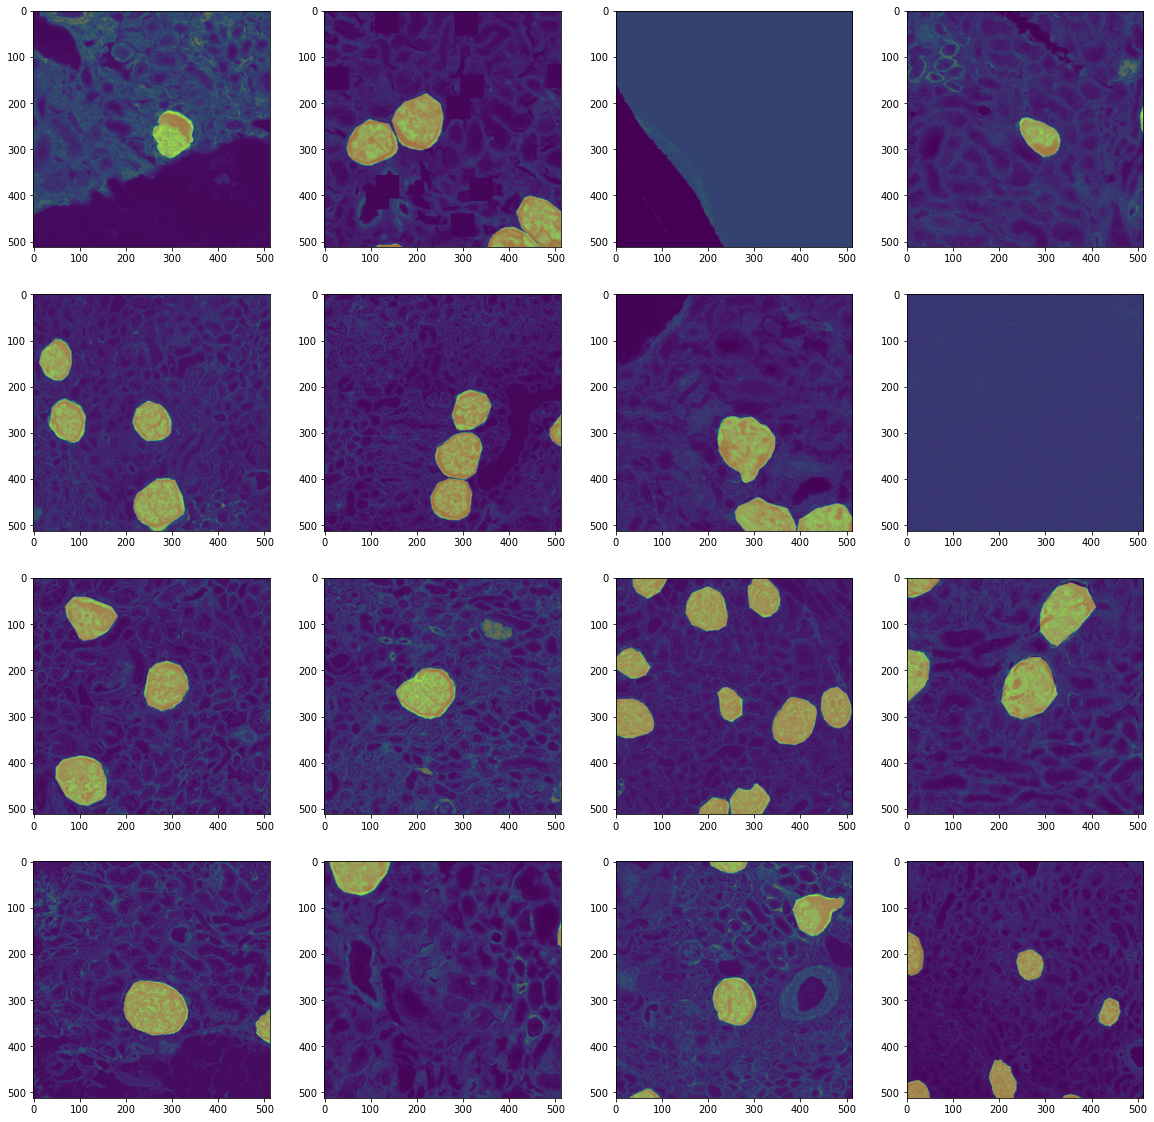

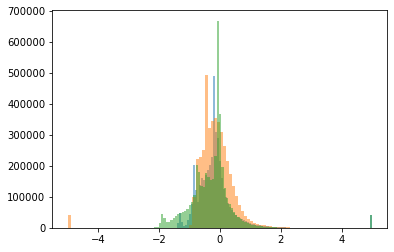

wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Start model fitting
996864 690262 512 649
935424 32335 512 609
1457664 1356867 512 949
996864 557199 512 649
1655808 62878 512 1078


epoch,train_loss,valid_loss,dice,iou,recall,precision,time


996864 266792 512 649
1064448 978845 512 693
1015296 482957 512 661
1115136 920211 512 726


In [ ]:
kf = KFold(cfg.n_splits, shuffle=True, random_state=42)

for i, (train_idx, val_idx) in enumerate(kf.split(files)):
    files_train, files_val = files[train_idx], files[val_idx]
    print('Training on', [x.name for x in files_train])
    
    # Datasets
    train_ds = HubmapRandomTileDataset(files_train, **ds_kwargs, **position_augmentation_kwargs)
    valid_ds = HubmapValidationDataset(files_val, **ds_kwargs)
    
    print ("Done til here!! ")
    
    # Model
    model = smp.Unet(encoder_name=cfg.encoder_name, 
                     encoder_weights=cfg.encoder_weights, 
                     in_channels=cfg.in_channels, 
                     classes=cfg.classes)
    print("Done")
    # Dataloader and learner
    dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=cfg.batch_size, after_batch=Normalize.from_stats(*cfg.stats))
    if torch.cuda.is_available(): dls.cuda(), model.cuda()
    
    if i==0: 
        show_batch(dls.one_batch())
        
    run = wandb.init(project='bricknet', reinit=True, config=cfg, name=f"default_with_phils_augment_{i}")

    cbs = [SaveModelCallback(monitor='dice'), ElasticDeformCallback, WandbCallback(log_preds=False, log_model=False)]
    learn = Learner(dls, model, metrics=cfg.metrics, wd=cfg.weight_decay, loss_func=cfg.loss_func, opt_func=ranger, cbs=cbs)
    if cfg.mixed_precision_training: learn.to_fp16()
    
    print ("Start model fitting")
    # Fit
    learn.fit_one_cycle(cfg.epochs, lr_max=cfg.max_learning_rate)
    learn.recorder.plot_metrics()
    
    # Save Model
    print ("Saving Model")
    state = {'model': learn.model.state_dict(), 'stats':cfg.stats}
    torch.save(state, f'unet_{cfg.encoder_name}_{i}.pth', pickle_protocol=2, _use_new_zipfile_serialization=False)
    print ("Model Saved")